In [1]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import xgboost as xgb
import numpy as np

shap.initjs()

1. [Load Data](#Load-data)
2. [Train Model](#Train-model)
3. [SHAP evaluation](#SHAP-evaluation)

## Load data

In [2]:
caseType = 2
txtSubname = 'contiPositiveAge'
oldData = pd.read_csv('./data/oldData{}.csv'.format(txtSubname)).iloc[:, 1:]
youngData = pd.read_csv('./data/youngData{}.csv'.format(txtSubname)).iloc[:, 1:]
totalData = pd.read_csv('./data/totalData{}.csv'.format(txtSubname)).iloc[:, 1:]
coef = np.loadtxt('./data/coef.txt')
B_sex, B_trt, B_age, B_int = coef[0], coef[1], coef[2], coef[3]
print(B_sex, B_trt, B_age, B_int)
totalData

65.0 35.0 45.0 95.0


,T,Age,AgeTag,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
0,1.0,0.28,-1.0,1.0,195.0,-65.0,199.966616,-72.963256,139.2,69.2,140.091105,66.638198,139.2,16.0,129.987863,19.166564
1,1.0,0.14,-1.0,1.0,195.0,-65.0,188.534435,-57.193869,119.6,49.6,121.403808,46.406782,119.6,23.0,127.079184,19.969171
2,-1.0,0.70,1.0,-1.0,-5.0,-125.0,-9.382402,-128.791270,-135.0,-65.0,-136.436100,-75.735351,-135.0,68.0,-140.986203,68.859754
3,1.0,0.04,-1.0,-1.0,-125.0,-5.0,-125.697061,-1.522448,-32.0,-102.0,-18.223095,-99.601897,-24.4,-102.0,-30.161104,-108.893942
4,1.0,0.18,-1.0,-1.0,-125.0,-5.0,-118.179846,-5.754429,-39.0,-109.0,-38.967583,-110.765390,-4.8,-109.0,2.005894,-106.929829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.0,0.98,1.0,-1.0,-5.0,-125.0,-7.057795,-130.890330,-149.0,-79.0,-145.511445,-72.952934,-149.0,107.2,-148.429670,103.788289
996,1.0,0.08,-1.0,-1.0,-125.0,-5.0,-123.763853,2.148185,-34.0,-104.0,-34.648330,-107.626314,-18.8,-104.0,-29.520529,-107.023702
997,1.0,0.08,-1.0,1.0,195.0,-65.0,190.409335,-71.021671,111.2,41.2,112.865682,39.057151,111.2,26.0,119.830089,23.074255
998,1.0,0.40,-1.0,1.0,195.0,-65.0,191.676938,-64.637119,156.0,86.0,155.196624,76.073283,156.0,10.0,157.932497,15.167533


In [3]:
X = totalData[["T", "Age", "Sex"]]
y = totalData["y"+str(caseType)]

## Train model

In [4]:
#Train model
model = xgb.XGBRegressor(objective="reg:squarederror",max_depth=5)
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## SHAP evaluation

In [5]:
explainer = shap.TreeExplainer(model)
shap_interaction = explainer.shap_interaction_values(X, tree_limit=-1)

In [6]:
#Get model predictions
y_pred = model.predict(X)

#Calculate mean prediction 
mean_pred = np.mean(y_pred)

#Sum of interaction values for first employee
sum_shap = np.sum(shap_interaction[0])

#Values below should be the same
print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(mean_pred+sum_shap))

Model prediction: 138.42999267578125
Mean prediction + interaction values: 138.4300079345703


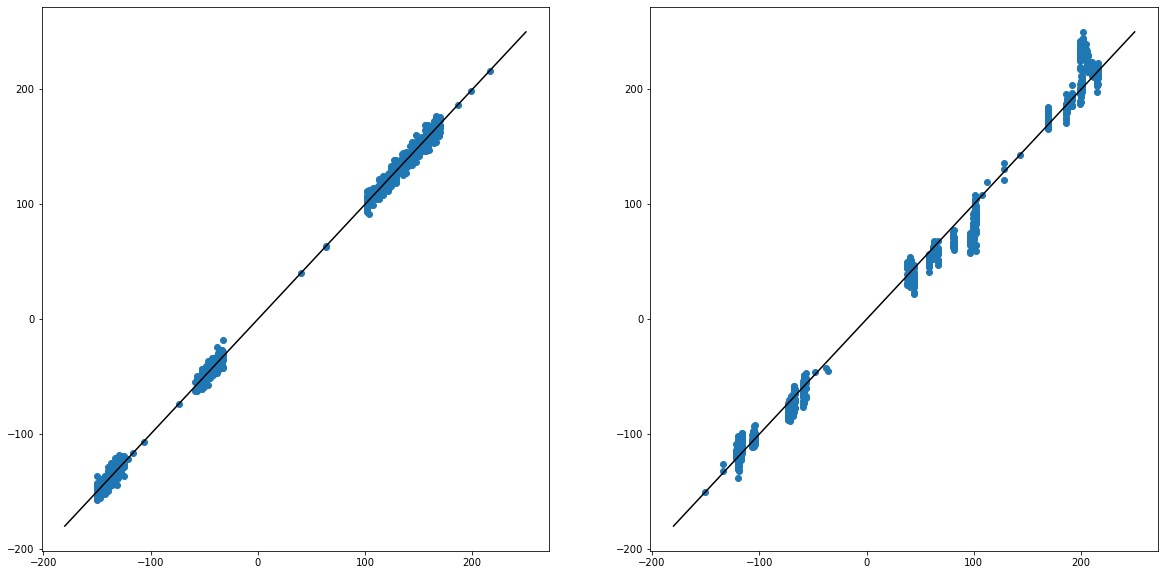

In [7]:
y_pred = model.predict(X)
cfX = X.copy()
cfX.iloc[:, 0] = - cfX.iloc[:, 0]
ycf_pred = model.predict(cfX)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(y_pred, y)
axs[1].scatter(ycf_pred, totalData["y{}CF".format(caseType)])
axs[0].plot([-180, 250], [-180, 250], color='black')
axs[1].plot([-180, 250], [-180, 250], color='black')

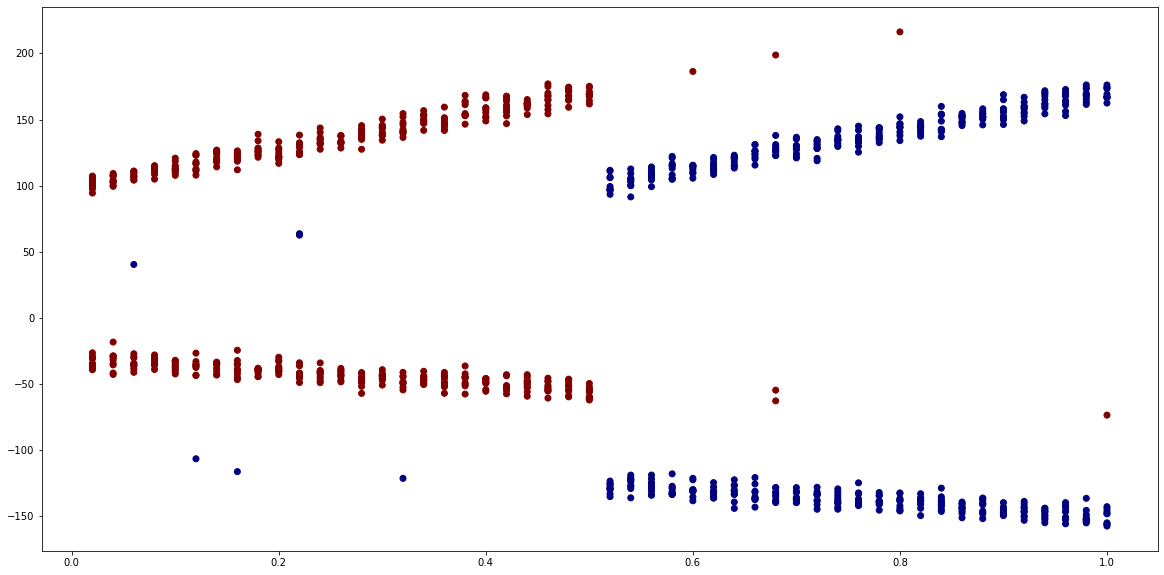

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.scatter(totalData["Age"], y, c=totalData["T"], cmap="jet")

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'T'), Text(0, 1.5, 'Age'), Text(0, 2.5, 'Sex')])

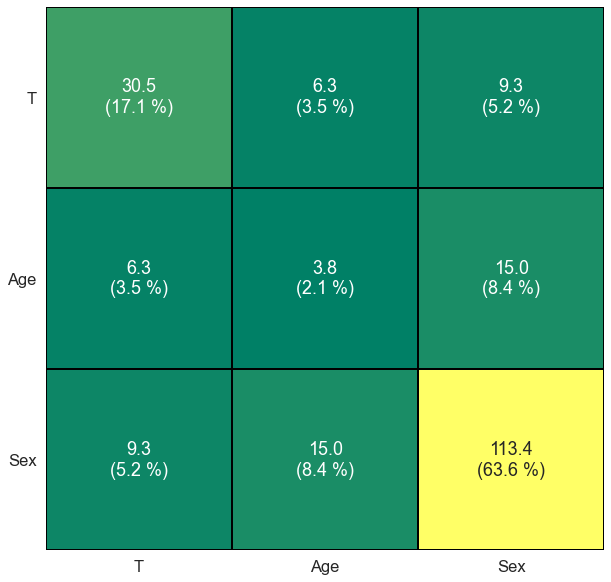

In [9]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)
totalSum = 0
for i in range(mean_shap.shape[0]):
    for j in range(mean_shap.shape[1]):
        if i <= j:
            totalSum += mean_shap[i, j]

label = []
for i in range(mean_shap.shape[0]):
    for j in range(mean_shap.shape[1]):
        label.append("{:.1f}\n({:.1f} %)".format(mean_shap[i, j], mean_shap[i, j]/totalSum*100))
label = np.array(label).reshape(mean_shap.shape)
# display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='summer',annot=label, fmt="",cbar=False,linewidths=1, linecolor='black')
plt.yticks(rotation=0) 

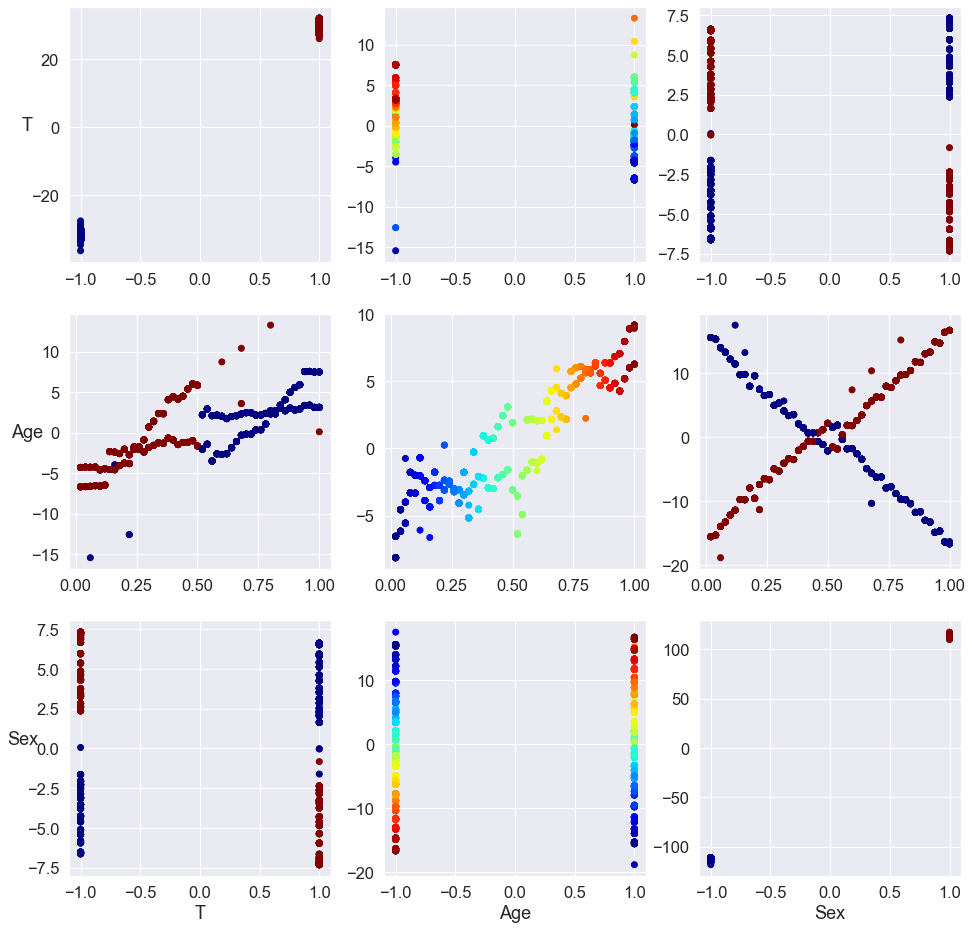

In [10]:
ticks = ["T", "Age", "Sex"]
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
for i in range(3):
    for j in range(3):
        axs[i, j].scatter(X.iloc[:, i], shap_interaction[:, i, j], c=X.iloc[:, j], cmap='jet')
        if j == 0:
            axs[i, j].set_ylabel(ticks[i], rotation=0)
        if i == 2:
            axs[i, j].set_xlabel(ticks[j], rotation=0)

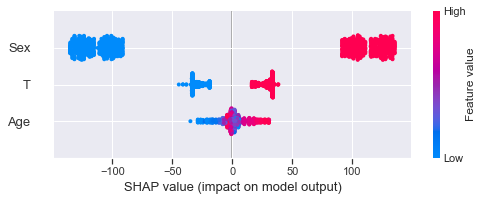

In [11]:
# Get SHAP values
shap_values = explainer(X)

#Display beeswarm plot
plt.figure()
shap.plots.beeswarm(shap_values)